In [1]:
import os

import numpy as np
import pandas as pd
import geopandas as gpd

import xarray as xr
import rioxarray
import rasterio

import scipy.ndimage as sni

import time

import warnings

import gc

from az_processing import *
from pos_processing import *
from connection_data_preparation import positionTestSplit, getSplitClasses
from planet_constants import Planet_Properties, Planet_CRS, Planet_Basemap, PLANET_GEOD 


/home/mlissoni/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
CYL_DATA_ROOT="__EJMAP_ROOT_DIR__/data/cyl_data/"
EJC_DATA_ROOT="__EJMAP_ROOT_DIR__/data/ejc_data/"
CONN_DATA_ROOT="__EJMAP_ROOT_DIR__/data/conn_data/"
MOSAIC_DIR="__EJMAP_ROOT_DIR__/data/mosaics/"

image_size = 224

distance_intervals = 5
#distance_right_edge = 1
#distance_right_step = 0.5
#distance_coef = 0.5

test_frac = 0.2
max_h_circum_default = 0.25
special_max_h_circums = {0: 0.75,
                     3: 0.5,
                     12: 0.5,
                     13: 0.5,
                     17: 0.5} #WARNING: the code does not fully support changes here

CRATER GEOMETRY, MOSAICS AND BUFFERS  

Computes the geometry data of the craters, generates the azimuthal mosaics and the images used to extract the buffer data.

HUMAN POSITIONS, GENERATE NEW 

Create lists of training and testing tile positions of a given crater or add tiles covering the whole basemap to an existing list (should be used only to create human_positions.csv if no crater-unique positions are used).

CYLINDRICAL POSITIONS, SUMMARISE 

Removes the tiles that have not been mapped, leaving only the completed ones.

If dealing with tile positions that are not crater-unique, first use the human positions to select the desired ones. Then run this cell once (with crater_mapping_complete set to False). Then map the positions and then run this cell again.

If dealing with crater-unique positions, map them and then run this cell.

AZIMUTHAL POSITIONS, CREATE  

Create the training and testing azimuthal tile positions (find squares inscribed in reprojected tile area) and extract the images from the mosaics.

AZIMUTHAL POSITIONS, ASSEMBLE  

Create the list of all tiles and the train/test splits. In each 'test_*' column, the excluded tiles are indicated with -1, the train and validation tiles with 0, the test tiles with 1.

EVAL AZIMUTHAL POSITIONS, CREATE 

Create the tiles for the evaluation and final mapping

CONNECTION IMAGES, CREATE  

Create data for the connection model (EJCONN)

#
#
FIGURES

Tile and rectangle (eval) positions

[11063. 10822.]
[10951 11175 11175 10951] [10710 10710 10934 10934]


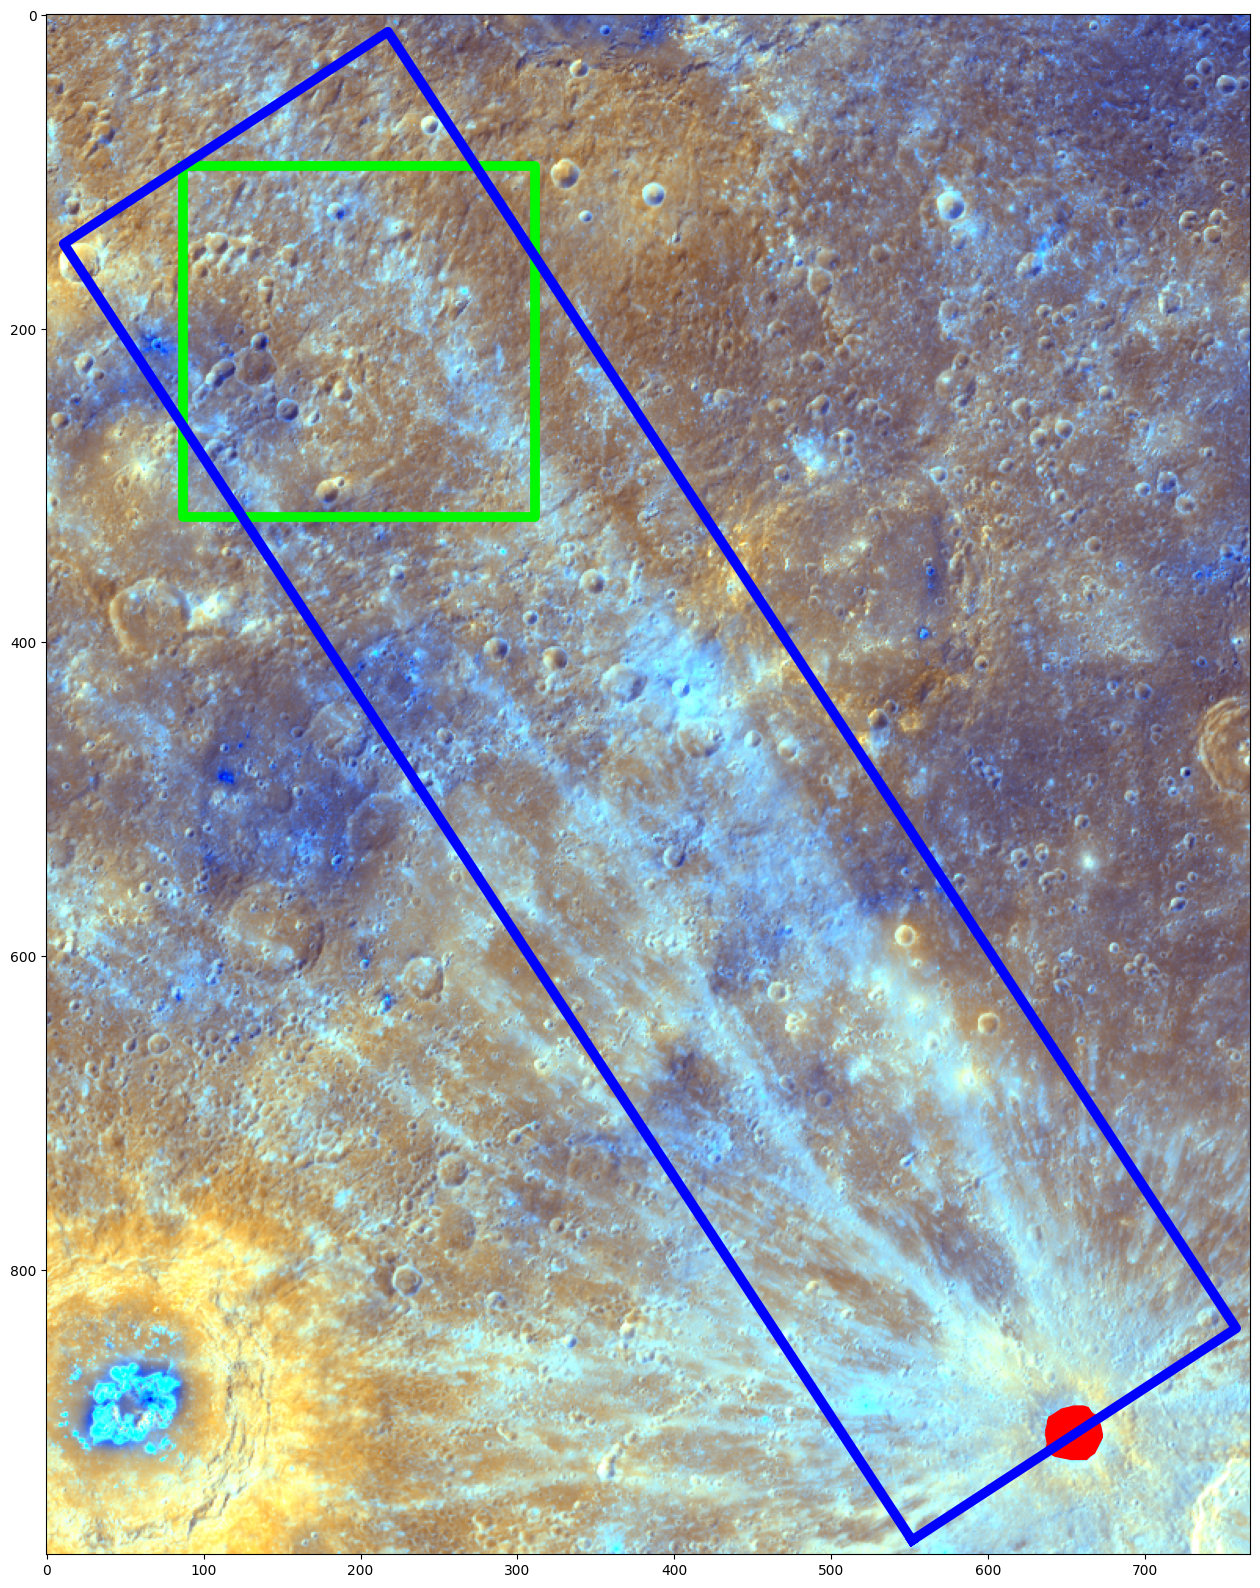

In [9]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray
import matplotlib.pyplot as plt

import rasterio
from rasterio.transform import AffineTransformer
from shapely import Polygon

from planet_constants import Planet_Basemap

CONN_DATA_ROOT="__EJMAP_ROOT_DIR__/data/conn_data/"
EJC_DATA_ROOT="__EJMAP_ROOT_DIR__/data/ejc_data/"
MOSAIC_DIR="__EJMAP_ROOT_DIR__/data/mosaics/"

crater_FID = 34
pos_index = 195 # Eval pos index

long_pixels = 448
rectangle_ratio = 4

if(long_pixels % (rectangle_ratio*2)>0):
    raise ValueError(f'The rectangle long side should be divisible by {rectangle_ratio*2}.')

fresh_craters_gdf = gpd.read_file(os.path.join(EJC_DATA_ROOT,'fresh_craters.shp')).set_index('crat_FID')
crater_FIDs, FID_counts = np.unique(fresh_craters_gdf.index.values, return_counts=True)

if(np.any(FID_counts!=1)):
    raise RuntimeError("Each crater should have a unique FID.")

az_resolution = Planet_Basemap.BASEMAP_RESOLUTION

positions = pd.read_csv(os.path.join(CONN_DATA_ROOT, 'eval_positions','eval_positions_crater_'+str(crater_FID)+'.csv'), index_col='eval_pos_index')

x_positions = positions['x'].values
y_positions = positions['y'].values
heights = positions['height'].values
widths = positions['width'].values

az_mosaic = rioxarray.open_rasterio(os.path.join(MOSAIC_DIR, 'azimuthal_mosaic_crater_'+str(crater_FID)+'.tif')).astype(np.uint8)

transformer = AffineTransformer(az_mosaic.rio.transform())

raster_half_size = int(az_mosaic.shape[1]/2)

az_crater_geom = fresh_craters_gdf.geometry.loc[[crater_FID]].to_crs(az_mosaic.rio.crs).iloc[0]
crater_geom_mask = rasterio.features.geometry_mask([az_crater_geom], 
                                                    az_mosaic[0,:,:].shape, 
                                                    transform=az_mosaic.rio.transform(), 
                                                    all_touched=True, invert=True).astype(np.float32)

pos_index_index = np.flatnonzero(positions.index.values==pos_index)[0]


centers = np.hstack([(x_positions+widths/2)[:,np.newaxis], (y_positions+heights/2)[:,np.newaxis]])

print(centers[pos_index_index,:])

corners_x = np.hstack([x_positions[:,np.newaxis], (x_positions+widths)[:,np.newaxis], (x_positions+widths)[:,np.newaxis], x_positions[:,np.newaxis]]) 
corners_y = np.hstack([y_positions[:,np.newaxis], y_positions[:,np.newaxis], (y_positions+heights)[:,np.newaxis], (y_positions+heights)[:,np.newaxis]]) 

print(corners_x[pos_index_index,:], corners_y[pos_index_index,:])

corner_center_dists = np.sqrt(np.square(corners_x - raster_half_size) + np.square(corners_y - raster_half_size))
furthest_corners = np.hstack([corners_x[np.arange(len(positions), dtype=int), np.argmax(corner_center_dists, axis=1)][:,np.newaxis], 
                              corners_y[np.arange(len(positions), dtype=int), np.argmax(corner_center_dists, axis=1)][:,np.newaxis]])

center_vectors = centers - np.array([[raster_half_size, raster_half_size]])
furthest_vectors = furthest_corners - np.array([[raster_half_size, raster_half_size]])

long_axis_vectors = center_vectors*np.sum(center_vectors*furthest_vectors, axis=1)[:,np.newaxis]/np.sum(np.square(center_vectors), axis=1)[:,np.newaxis]
long_sides = np.linalg.norm(long_axis_vectors, axis=1)
short_sides = long_sides/rectangle_ratio

long_versors = long_axis_vectors/long_sides[:,np.newaxis]
short_versors = np.hstack([long_versors[:,[1]], np.negative(long_versors[:,[0]])])
short_versors = short_versors/np.linalg.norm(short_versors, axis=1)[:,np.newaxis]

rectangle_corners = np.repeat(np.array([[raster_half_size, raster_half_size]]), len(positions), axis=0)+short_versors*short_sides[:,np.newaxis]/2
rectangle_corners = rectangle_corners[:,np.newaxis,:]
rectangle_corners = np.concatenate([rectangle_corners, rectangle_corners[:, [0], :] + long_versors[:, np.newaxis, :]*long_sides[:,np.newaxis,np.newaxis]], axis=1)
rectangle_corners = np.concatenate([rectangle_corners, rectangle_corners[:, [1], :] - short_versors[:, np.newaxis, :]*short_sides[:,np.newaxis,np.newaxis]], axis=1)
rectangle_corners = np.concatenate([rectangle_corners, rectangle_corners[:, [2], :] - long_versors[:, np.newaxis, :]*long_sides[:,np.newaxis,np.newaxis]], axis=1)
rectangle_corners = np.concatenate([rectangle_corners, rectangle_corners[:, [0], :]], axis=1)

rectangle_geom_list = []

plt.figure(figsize=(20,20))


position_series = positions.loc[pos_index,:]
pos_y = position_series.loc['y']
pos_x = position_series.loc['x']
pos_height = position_series.loc['height']
pos_width = position_series.loc['width']

rectangle_px = rectangle_corners[pos_index_index,:,:]
long_versor = long_versors[pos_index_index,:]
short_versor = short_versors[pos_index_index,:]
long_side = long_sides[pos_index_index]


rectangle_m = (rectangle_px*np.array([[1,-1]]) + np.array([[-raster_half_size,raster_half_size]])) * az_resolution
rectangle_geom_list.append(Polygon(rectangle_m))

start_px = (int(np.amin(rectangle_px[:,0])-10),int(np.amin(rectangle_px[:,1])-10))
end_px = (int(np.amax(rectangle_px[:,0])+10), int(np.amax(rectangle_px[:,1])+10))

mosaic_bkg = az_mosaic.values[:,start_px[1]:end_px[1], start_px[0]:end_px[0]]

crat_x, crat_y = az_crater_geom.exterior.coords.xy

crat_rows, crat_cols = transformer.rowcol(np.array(crat_x), np.array(crat_y))


plt.imshow(np.transpose(mosaic_bkg,(1,2,0)))

plt.fill(np.array(crat_cols)-start_px[0], np.array(crat_rows) - start_px[1], color='red')
plt.plot(np.array([pos_x, pos_x+pos_width, pos_x+pos_width, pos_x, pos_x])-start_px[0],
         np.array([pos_y, pos_y, pos_y+pos_height, pos_y+pos_height, pos_y])-start_px[1], color='#00f800',linewidth=7)
plt.plot(rectangle_px[:,0]-start_px[0], rectangle_px[:,1]-start_px[1], color='blue', linewidth=7)
plt.show()
    

Crater annulus

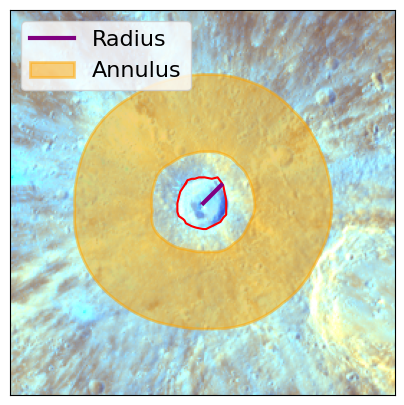

In [2]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray
import matplotlib.pyplot as plt

import rasterio
from rasterio.transform import AffineTransformer
from shapely import Polygon
import shapely

from planet_constants import Planet_Basemap

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Annulus
from rasterio.transform import AffineTransformer

from matplotlib.path import Path
from matplotlib.patches import PathPatch

EJC_DATA_ROOT="__EJMAP_ROOT_DIR__/data/ejc_data/"

fresh_craters_gdf = gpd.read_file(os.path.join(EJC_DATA_ROOT,'fresh_craters.shp')).set_index('crat_FID')

az_resolution = Planet_Basemap.BASEMAP_RESOLUTION
    
crater_FID = 34
radii_dim = 7.5
buffer_min = 2
buffer_max = 5

az_buffer = rioxarray.open_rasterio(os.path.join(EJC_DATA_ROOT, 'buffers', 'az_crater_'+str(crater_FID)+'.tif')).astype(np.uint8)

transformer = AffineTransformer(az_buffer.rio.transform())

raster_half_size = int(az_buffer.shape[1]/2)

radius_px = fresh_craters_gdf.loc[crater_FID, 'radius']/az_resolution

start_px = (raster_half_size-int(radii_dim*radius_px), raster_half_size-int(radii_dim*radius_px))
end_px = (raster_half_size+int(radii_dim*radius_px), raster_half_size+int(radii_dim*radius_px))

crater_mosaic = az_buffer.values[:, start_px[0]:end_px[0], start_px[1]:end_px[1]]
#crat_annulus = Annulus((int(radii_dim*radius_px), int(radii_dim*radius_px)), 5*radius_px, 3*radius_px, alpha=0.5, color='orange', label='Annulus')

az_crater_geom = fresh_craters_gdf.geometry.loc[[crater_FID]].to_crs(az_buffer.rio.crs).iloc[0]
crat_x, crat_y = az_crater_geom.exterior.coords.xy

crat_rows, crat_cols = transformer.rowcol(np.array(crat_x), np.array(crat_y))
crat_rows = np.array(crat_rows)-start_px[0]
crat_cols = np.array(crat_cols)-start_px[1]

crater_poly_px = Polygon(np.hstack([crat_cols[:,np.newaxis],crat_rows[:,np.newaxis]]))

# Create annulus by subtracting the inner polygon from the outer one.

buffer_min -= 1
buffer_max -= 1

crater_buffer_px_max = crater_poly_px.buffer(buffer_max*radius_px) 
crater_buffer_px_min = crater_poly_px.buffer(buffer_min*radius_px)
crater_buffer_px = crater_buffer_px_max.difference(crater_buffer_px_min)

outer_coords = crater_buffer_px.exterior.coords.xy
outer_coords = np.hstack([np.array(outer_coords[0])[:,np.newaxis],np.array(outer_coords[1])[:,np.newaxis]])
hole_coords = crater_buffer_px.interiors[0].coords.xy
hole_coords = np.hstack([np.array(hole_coords[0])[:,np.newaxis],np.array(hole_coords[1])[:,np.newaxis]])

vertices = np.vstack([outer_coords, hole_coords])
codes = [Path.MOVETO] + [Path.LINETO] * (len(outer_coords[:,0]) - 2) + [Path.CLOSEPOLY]
codes = codes + [Path.MOVETO] + [Path.LINETO] * (len(hole_coords[:,0]) - 2) + [Path.CLOSEPOLY] 

# Create the path and patch
path = Path(vertices, codes)
patch = PathPatch(path, facecolor='orange', edgecolor='orange', linewidth=2, alpha=0.5, label='Annulus')


fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.imshow(np.transpose(crater_mosaic, (1,2,0)))
#ax.add_patch(crat_annulus)
ax.plot(crat_rows, crat_cols, color='red')
ax.plot([int(radii_dim*radius_px),int(radii_dim*radius_px)+radius_px/np.sqrt(2)], [int(radii_dim*radius_px),int(radii_dim*radius_px)-radius_px/np.sqrt(2)], 
        color='purple', linewidth=3, label='Radius')
ax.add_patch(patch)
ax.legend(fontsize=16)
ax.set_xticks([])
ax.set_yticks([])
plt.show()



Output tile mask

/home/mlissoni/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


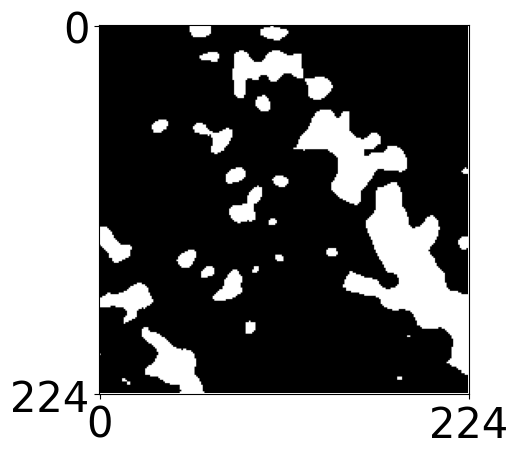

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray
import matplotlib.pyplot as plt

from planet_constants import Planet_Basemap
from az_processing import fillAz

crater_FID = 34
pos_index = 195 # Eval pos index

CONN_DATA_ROOT="__EJMAP_ROOT_DIR__/data/conn_data/"
EJC_DATA_ROOT="__EJMAP_ROOT_DIR__/data/ejc_data/"

output_mask_dir = "__EJMAP_ROOT_DIR__/results/output_masks/ejc-version-200_conn-version-32_test-set-61_x20/"

fresh_craters_gdf = gpd.read_file(os.path.join(EJC_DATA_ROOT,'fresh_craters.shp')).set_index('crat_FID')

az_resolution = Planet_Basemap.BASEMAP_RESOLUTION

center_lon = fresh_craters_gdf.loc[crater_FID, 'center_lon']
center_lat = fresh_craters_gdf.loc[crater_FID, 'center_lat']

positions = pd.read_csv(os.path.join(CONN_DATA_ROOT, 'eval_positions','eval_positions_crater_'+str(crater_FID)+'.csv'), index_col='eval_pos_index')

position_series = positions.loc[pos_index,:]
pos_y = position_series.loc['y']
pos_x = position_series.loc['x']
pos_height = position_series.loc['height']
pos_width = position_series.loc['width']

az_mask = rioxarray.open_rasterio(os.path.join(output_mask_dir, "azimuthal_mask_crater_"+str(crater_FID)+".tif")).astype(np.uint8)

az_mask = fillAz(az_mask, (center_lon, center_lat))

pos_mask = az_mask[0, pos_y:pos_y+pos_height, pos_x:pos_x+pos_width].values*1.0

plt.figure()
plt.imshow(pos_mask, cmap='binary_r')
plt.xticks([0,224], fontsize=30)
plt.yticks([0,224], fontsize=30)
plt.show()


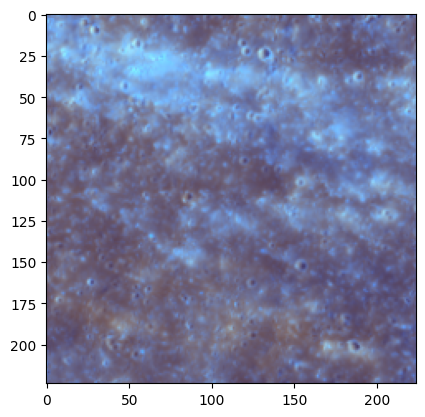

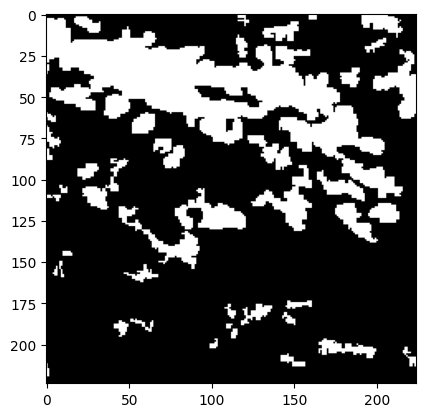

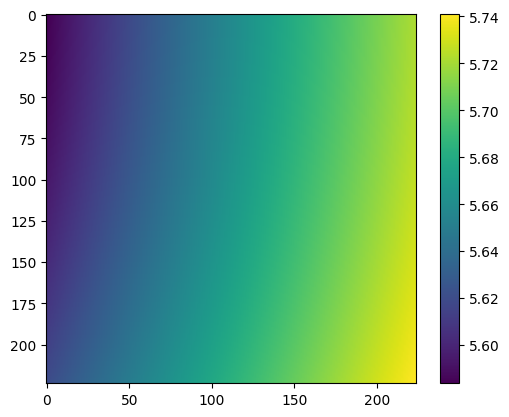

In [3]:

import numpy as np
import matplotlib.pyplot as plt

pos_index = 249
crat_FID = 34
directory = "__EJMAP_ROOT_DIR__/data/ejc_data/"

img_arr = np.load(directory+'images/image_'+str(pos_index)+'_crater_'+str(crat_FID)+'.npy')
mask_arr = np.load(directory+'masks/mask_'+str(pos_index)+'_crater_'+str(crat_FID)+'.npy')
dist_arr = np.load(directory+'distances/distance_'+str(pos_index)+'_crater_'+str(crat_FID)+'.npy')


plt.figure()
plt.imshow(np.transpose(img_arr, (1,2,0)))
#plt.imshow(mask_arr, cmap='binary_r', alpha=0.2)
plt.show()

plt.figure()
plt.imshow(mask_arr, cmap='binary_r')
plt.show()

plt.figure()
plt.imshow(np.log10(dist_arr), cmap='viridis')
plt.colorbar()
plt.show()

Connection data (eval)

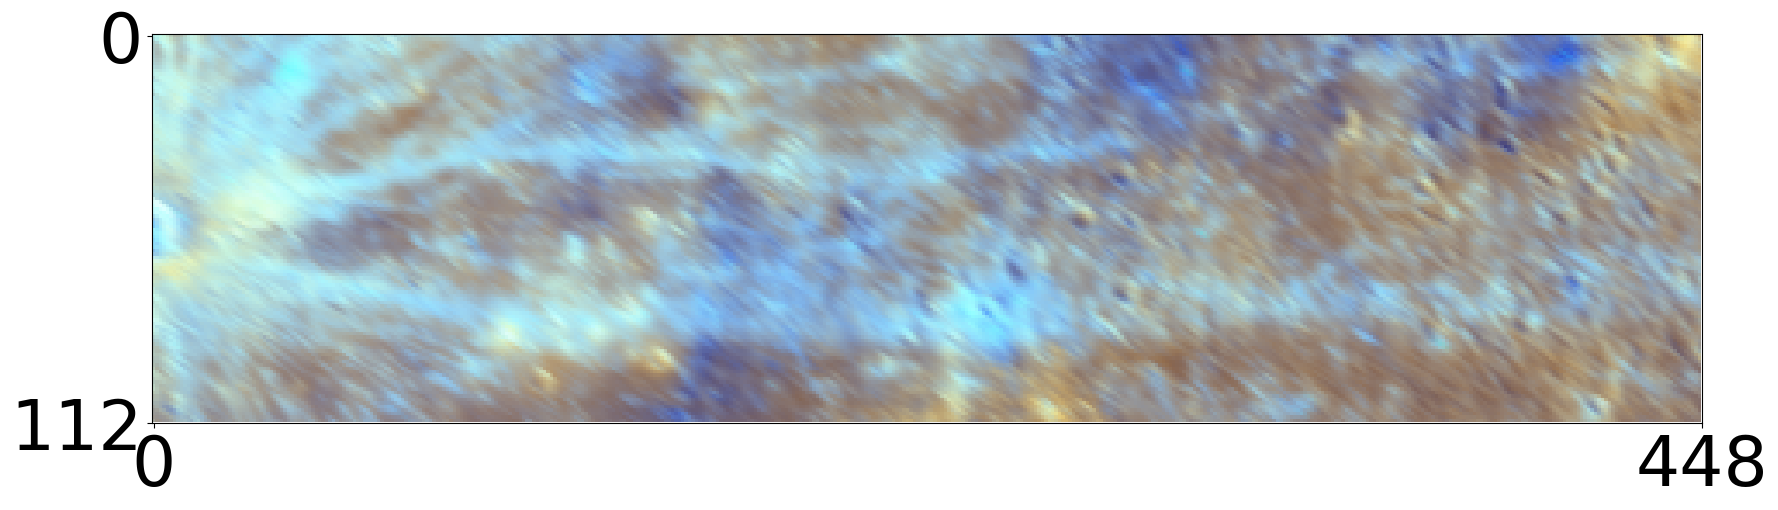

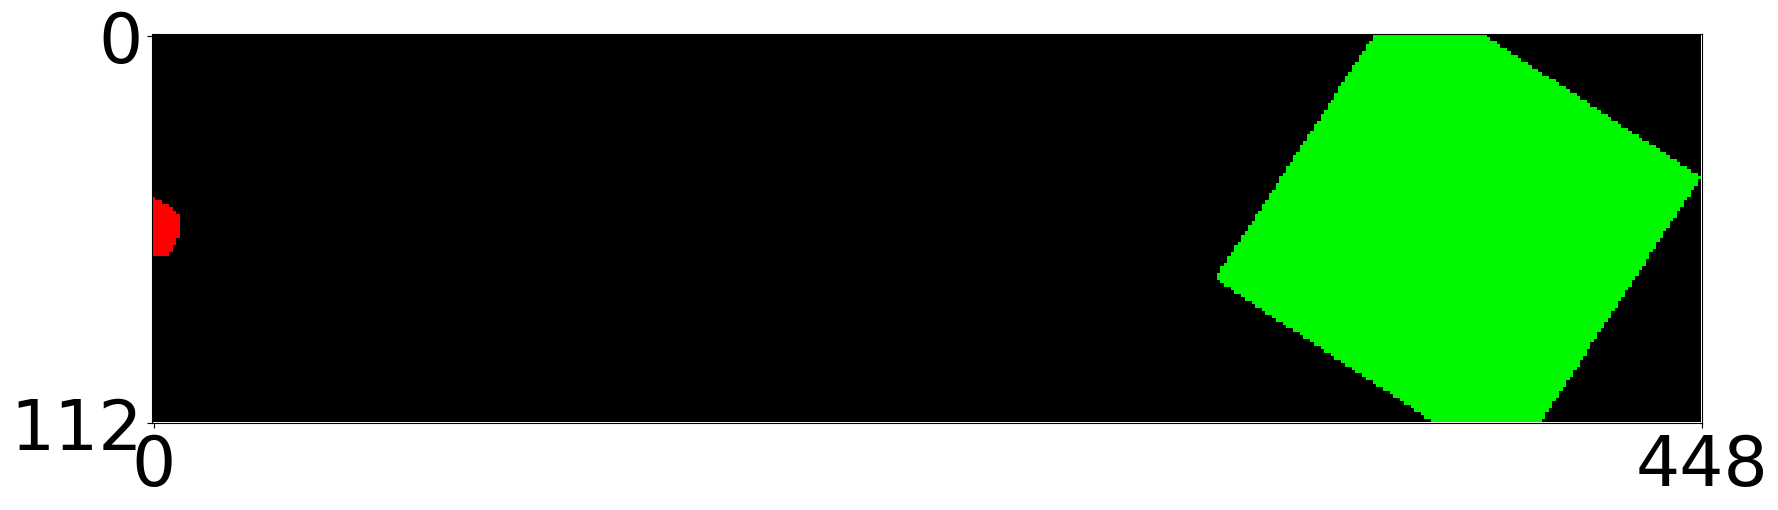

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

connection_dir = '__EJMAP_ROOT_DIR__/data/conn_data/'

crater_FID = 34
pos_index = 195
dst_arr = np.load(os.path.join(connection_dir, 'eval_images', 'eval_image_'+str(pos_index)+'_crater_'+str(crater_FID)+'.npy'))
att_arr = np.load(os.path.join(connection_dir, 'eval_attention', 'eval_att_'+str(pos_index)+'_crater_'+str(crater_FID)+'.npy'))

norm=plt.Normalize(0,2)
cmap = LinearSegmentedColormap.from_list("", ["black","red","#00f800"])

plt.figure(figsize=(20,10))
plt.imshow(np.transpose(dst_arr,(1,2,0)))
plt.xticks([0,448], fontsize=50)
plt.yticks([0,112], fontsize=50)
plt.show()

plt.figure(figsize=(20,10))
plt.imshow(np.transpose(att_arr,(1,2,0)), cmap=cmap, norm=norm)
plt.xticks([0,448], fontsize=50)
plt.yticks([0,112], fontsize=50)
plt.show()

Connection data (TVT)

/home/mlissoni/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


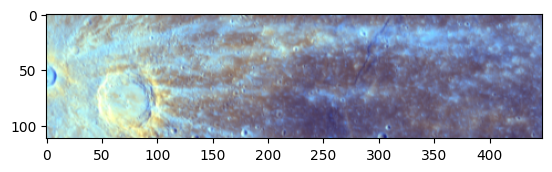

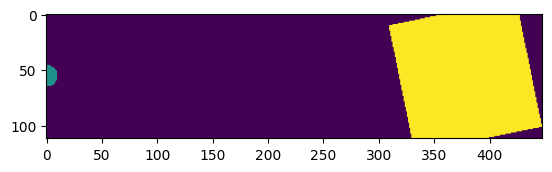

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

crater_FID = 34
pos_index = 249

connection_dir = '__EJMAP_ROOT_DIR__/data/conn_data/'

dst_arr = np.load(os.path.join(connection_dir, 'images', 'image_'+str(pos_index)+'_crater_'+str(crater_FID)+'.npy'))
att_arr = np.load(os.path.join(connection_dir, 'attention', 'att_'+str(pos_index)+'_crater_'+str(crater_FID)+'.npy'))

plt.figure()
plt.imshow(np.transpose(dst_arr,(1,2,0)))
plt.show()

plt.figure()
plt.imshow(np.transpose(att_arr/2.0,(1,2,0)))
plt.show()

Segmentation data (eval)

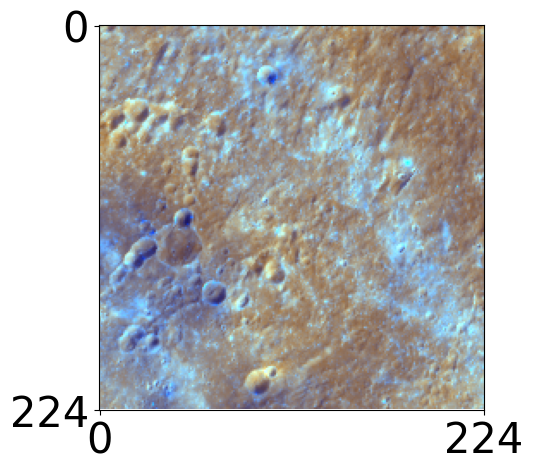

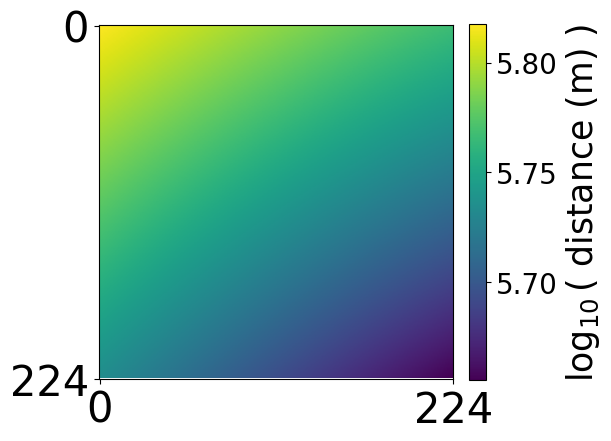

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt

crater_FID = 34
pos_index = 195 # Eval pos index

directory = '__EJMAP_ROOT_DIR__/data/ejc_data/'

img_arr = np.load(os.path.join(directory, 'eval_images', 'eval_image_'+str(pos_index)+'_crater_'+str(crater_FID)+'.npy'))
dst_arr = np.load(os.path.join(directory, 'eval_distances', 'eval_distance_'+str(pos_index)+'_crater_'+str(crater_FID)+'.npy'))

plt.figure(figsize=(5,5))
plt.imshow(np.transpose(img_arr,(1,2,0)))
plt.xticks([0,224], fontsize=30)
plt.yticks([0,224], fontsize=30)
plt.show()

fig, ax = plt.subplots(1,1,figsize=(5,5))
cax = ax.imshow(np.transpose(np.log10(dst_arr),(0,1)))#,(1,2,0)))
ax.set_xticks([0,224])
ax.set_yticks([0,224])
ax.tick_params(axis='both', which='major', labelsize=30)
cbar = fig.colorbar(cax, fraction=0.046, pad=0.04, ticks = np.array([5.70, 5.75, 5.80]))
cbar.set_label(label=r"$\log_{10}$( distance (m) )", size=25)
cbar.ax.tick_params(labelsize=20)
plt.show()

In [ ]:
Segmentation data (TVT)

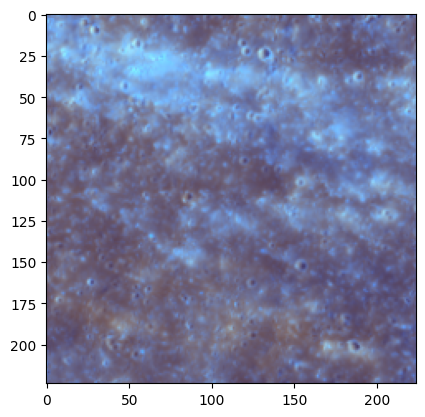

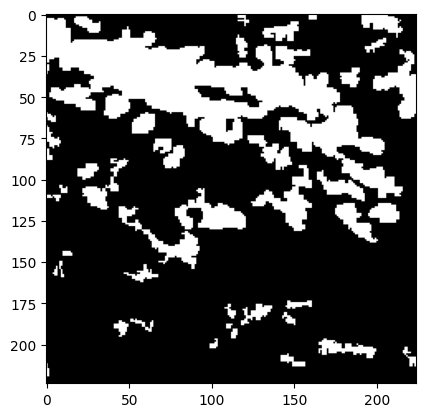

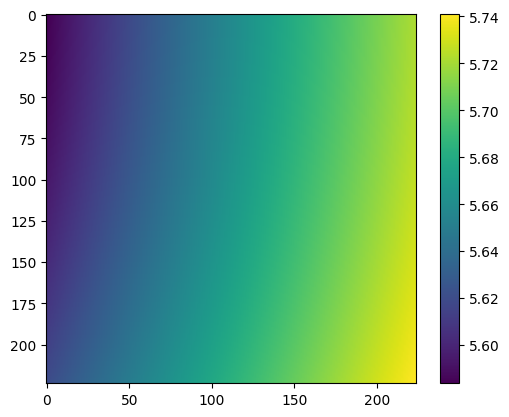

In [2]:

import numpy as np
import matplotlib.pyplot as plt

pos_index = 249
crat_FID = 34

directory = '__EJMAP_ROOT_DIR__/data/ejc_data/'

img_arr = np.load(directory+'images/image_'+str(pos_index)+'_crater_'+str(crat_FID)+'.npy')
mask_arr = np.load(directory+'masks/mask_'+str(pos_index)+'_crater_'+str(crat_FID)+'.npy')
dist_arr = np.load(directory+'distances/distance_'+str(pos_index)+'_crater_'+str(crat_FID)+'.npy')


plt.figure()
plt.imshow(np.transpose(img_arr, (1,2,0)))
#plt.imshow(mask_arr, cmap='binary_r', alpha=0.2)
plt.show()

plt.figure()
plt.imshow(mask_arr, cmap='binary_r')
plt.show()

plt.figure()
plt.imshow(np.log10(dist_arr), cmap='viridis')
plt.colorbar()
plt.show()

#
#
OTHER

TV-Test splits where the test set is the same as in `test_set_base`, while the TV set are composed only of the first `num_sample` tile locations to be mapped.

In [4]:
import os
import numpy as np
import pandas as pd

EJC_DATA_ROOT="__EJMAP_ROOT_DIR__/data/ejc_data/"

all_positions_path = os.path.join(CONN_DATA_ROOT, 'az_positions_all.csv')
test_set_base = 61

all_positions = pd.read_csv(all_positions_path)

print(len(all_positions), len(np.unique(all_positions['pos_index'])))

sample_nums = [25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275]

test_set_start = 95

for i, num_sample in enumerate(sample_nums):
    test_set = test_set_start + i
    test_set_str = 'test_'+str(test_set)
    all_positions[test_set_str] = all_positions['test_'+str(test_set_base)]
    all_positions.loc[(all_positions['test_'+str(test_set_base)]==0) & (all_positions['pos_index']>=num_sample),test_set_str] = -1

# Uncomment to save
'''
all_positions.to_csv(all_positions_path, index=False)
'''

35700 300


Check the split classes distribution of the TV-Test split and Train-Validation split

In [4]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedShuffleSplit

test_set = 61
val_seg = True # If True, gives the Train and Val numbers for the Segmentation model. If False, for the Connection model
val_frac = 0.1

test_set_col = 'test_'+str(test_set)

CONN_DATA_ROOT="__EJMAP_ROOT_DIR__/data/conn_data/"

all_positions_path = os.path.join(CONN_DATA_ROOT, 'az_positions_all.csv')

all_positions_df = pd.read_csv(all_positions_path)

print(np.unique(all_positions_df[test_set_col], return_counts=True))
print('TVT')
print(np.unique(all_positions_df.loc[all_positions_df[test_set_col]>=0, 'split_class'], return_counts=True))
print(np.unique(all_positions_df.loc[all_positions_df[test_set_col]>=0, 'num_1']>0, return_counts=True))
print('TV')
print(np.unique(all_positions_df.loc[all_positions_df[test_set_col]==0, 'split_class'], return_counts=True))
print(np.unique(all_positions_df.loc[all_positions_df[test_set_col]==0, 'num_1']>0, return_counts=True))
print('Test')
print(np.unique(all_positions_df.loc[all_positions_df[test_set_col]==1, 'split_class'], return_counts=True))
print(np.unique(all_positions_df.loc[all_positions_df[test_set_col]==1, 'num_1']>0, return_counts=True))

num_thres = 0 if val_seg else -1
split_classes = all_positions_df.loc[(all_positions_df[test_set_col]==0) & (all_positions_df['num_1']>num_thres), 'split_class'].values

tv_indices = np.arange(len(split_classes), dtype=int)

splitter = StratifiedShuffleSplit(n_splits=1, test_size=int(len(tv_indices)*val_frac))
train_indices, val_indices = next(splitter.split(np.zeros(len(tv_indices)), split_classes[tv_indices]))

train_indices = tv_indices[train_indices]
val_indices = tv_indices[val_indices]

val_classes, val_class_count = np.unique(split_classes[val_indices], return_counts=True)
train_classes, train_class_count = np.unique(split_classes[train_indices], return_counts=True)

print('')
print('Validation:', val_classes, val_class_count, np.sum(val_class_count), np.sum(val_class_count[val_classes < 5]), np.sum(val_class_count[val_classes >= 5]))
print('Train:', train_classes, train_class_count, np.sum(train_class_count), np.sum(train_class_count[train_classes < 5]), np.sum(train_class_count[train_classes >= 5]))


(array([-1,  0,  1]), array([30219,  4385,  1096]))
TVT
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([1639, 2993,  290,  151,   61,  264,   48,   20,   12,    3]))
(array([False,  True]), array([5134,  347]))
TV
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([1311, 2395,  232,  121,   49,  211,   38,   16,   10,    2]))
(array([False,  True]), array([4108,  277]))
Test
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([328, 598,  58,  30,  12,  53,  10,   4,   2,   1]))
(array([False,  True]), array([1026,   70]))

Validation: [5 6 7 8] [21  4  1  1] 27 0 27
Train: [5 6 7 8 9] [190  34  15   9   2] 250 0 250


Create pair of TV-Test splits comprising different craters

In [ ]:
import os
import pandas as pd
import numpy as np

conn_data_root = '__EJMAP_ROOT_DIR__/data/conn_data/'

all_pos_path = os.path.join(conn_data_root, 'az_positions_all.csv')

all_positions = pd.read_csv(all_pos_path)

big_craters = [0, 3, 5, 8, 10, 12, 13, 14, 
               15, 17, 22, 23, 24, 25, 26, 
               28, 29, 30, 31, 33, 34, 35, 
               37, 39, 40, 41, 44, 45, 47, 
               48, 49, 50, 51, 59, 61, 62, 
               67, 71, 72, 78, 90, 98, 99, 
               112, 32, 46]

small_craters = [36, 38, 43, 52, 54, 55, 56, 
                 57, 58, 63, 64, 65, 66, 68, 
                 69, 70, 73, 74, 76, 77, 79, 
                 80, 82, 83, 84, 85, 86, 87, 
                 88, 89, 91, 92, 93, 94, 95, 
                 96, 97, 100, 101, 102, 103, 
                 104, 105, 106, 107, 108, 109, 
                 110, 111, 113, 114, 115, 116, 
                 117, 118, 53, 119, 120, 121, 
                 122, 123, 124, 125, 126, 127, 
                 128, 129, 130, 131, 132, 133, 
                 134, 135]

all_positions['test_62'] = all_positions['test_49'].values
all_positions.loc[np.isin(all_positions['crat_FID'], small_craters), 'test_62'] = -1

all_positions['test_63'] = all_positions['test_49'].values
all_positions.loc[np.isin(all_positions['crat_FID'], big_craters), 'test_63'] = -1

# Uncomment to save
'''
all_positions.to_csv(all_pos_path, index=False)
'''